# Building a GPT

## Load dataset

In [118]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print('Length of dataset in characters:', len(text))

Length of dataset in characters: 1115394


The first 400 characters are:

In [119]:
print(text[:400])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


## Vocabulary size

**Vocabulary size** is the number of unique characters.

**Note:** *chars[0]* is the new line character, *'\n'*. *chars[1]* is the space character, *' '*.

In [120]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

print('Unique characters:', ''.join(chars))
print('Vocabulary size:', vocab_size)

Unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocabulary size: 65


## Tokenizer

**Tokenize** means convert the raw text as a string to some sequence of integers according to some vocabulary of possible elements. 

We are building a character level language model so our tokenizer is going to simply translate individual characters into integers using a **lookup table**.

In [121]:
# mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

# Encoder: take a string, output a list of integers
encode = lambda s: [stoi[c] for c in s]

# Decoder: take a list of integers, output a string
decode = lambda l: ''.join([itos[i] for i in l])

print('Encoder output:', encode('hii there'))
print('Decoder output:', decode([46, 47, 47, 1, 58, 46, 43, 56, 43]))

Encoder output: [46, 47, 47, 1, 58, 46, 43, 56, 43]
Decoder output: hii there


Google uses [SentencePiece](https://github.com/google/sentencepiece?tab=readme-ov-file) tokenizer to also encode text into integers but in a different schema and using a different vocabulary. SentencePiece does not encode indivual characters or entire words but **sub-words units**. ChatGPT uses the OpenAI's [tiktoken](https://github.com/openai/tiktoken) library.

In [122]:
import tiktoken

enc = tiktoken.get_encoding('gpt2')
print('Vocabulary size:', enc.n_vocab)

print('Encoder output:', enc.encode('hii there'))
print('Decoder output:', enc.decode([71, 4178, 612]))

Vocabulary size: 50257
Encoder output: [71, 4178, 612]
Decoder output: hii there


## Build dataset

We can now encode the entire text dataset and store it into a PyTorch tensor:

In [123]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data[:400]) # the earlier 400 characters will look like this to the GPT

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

Split up the data into train and validation sets:

In [124]:
n = int(0.9*len(data))
train_data = data[:n] # 90%
val_data = data[n:]   # 10%

## Time dimension

We cannot feed the entire training set into a transformer all at once because that would be computationally very expensive. Thus, when training the transformer we sample random little **chunks** out of the training set and train just a chunk at a time. The maximum length of those chunks is the **block size**.


In a chunk of nine characters there's actually eight individual examples packed into it (see below). That's because all of these characters follow each other so when we plug the chunk into a transformer, it simultaneously trains to make a prediction for every example.


We train on all the eight examples not just for efficiency but to make the transformer network used to seeing **contexts of size 1 up to block size**. That is useful later during inference because we can start the sampling generation with just 1 character. Then, the transformer knows how to predict the next characters all the way up to block size. After block size, it starts truncating.

In [125]:
block_size = 8

print(f'Chunk: {train_data[:block_size+1].tolist()} \n')

x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f'{t+1}) When context is {context.tolist()} the target is {target}')

Chunk: [18, 47, 56, 57, 58, 1, 15, 47, 58] 

1) When context is [18] the target is 47
2) When context is [18, 47] the target is 56
3) When context is [18, 47, 56] the target is 57
4) When context is [18, 47, 56, 57] the target is 58
5) When context is [18, 47, 56, 57, 58] the target is 1
6) When context is [18, 47, 56, 57, 58, 1] the target is 15
7) When context is [18, 47, 56, 57, 58, 1, 15] the target is 47
8) When context is [18, 47, 56, 57, 58, 1, 15, 47] the target is 58


## Batch dimension

Because GPUs are very good at **parallel processing** of data, we have **batches of multiple chunks** stacked up in a single tensor feeding into a transformer. Thus, multiple chunks are processed at the same time but completely independently.

In [126]:
torch.manual_seed(1337)

batch_size = 4 # number of chunks per bacth
block_size = 8 # chunks maximum context length

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y


xb, yb = get_batch('train')
print('Inputs shape:', tuple(xb.shape))
print(xb)
print('\nTargets shape:', tuple(yb.shape))
print(yb)
print('\n\n')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f'{t+1}) When context is {context.tolist()} the target is {target}')

Inputs shape: (4, 8)
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])

Targets shape: (4, 8)
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])



1) When context is [24] the target is 43
2) When context is [24, 43] the target is 58
3) When context is [24, 43, 58] the target is 5
4) When context is [24, 43, 58, 5] the target is 57
5) When context is [24, 43, 58, 5, 57] the target is 1
6) When context is [24, 43, 58, 5, 57, 1] the target is 46
7) When context is [24, 43, 58, 5, 57, 1, 46] the target is 43
8) When context is [24, 43, 58, 5, 57, 1, 46, 43] the target is 39
1) When context is [44] the target is 53
2) When context is [44, 53] the target is 56
3) When context is [44, 53, 56] the target is 1
4) When context is [44, 53, 56, 1] the target is 58

# Bigram model

**Note:**
- B = Bacth (batch_size), in our case 32
- T = Time (block_size), in our case 8
- C = Channel (vocab_size), in our case 64

In [127]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B, T) tensor of integers
        
        # each token reads off the logits for the next token from a lookup table
        logits = self.token_embedding_table(idx) # (B, T, C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is the current context
        # in each iteration idx will grow:
        # (B, T), (B, T+1), (B, T+2), ..., (B, T+max_new_tokens)

        for _ in range(max_new_tokens):

            # get logits for current context (calling forward method)
            logits, _ = self(idx) # (B, T, C)

            # focus only on the last time-step because
            # those are the predictions for what comes next
            logits = logits[:, -1, :] # (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        
        return idx

Logits shape: (32, 65)
Loss: 4.878634929656982


In [ ]:
model = BigramLanguageModel(vocab_size)

## Train the model

Create a PyTorch optimizer:

In [129]:
learning_rate = 1e-3

optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

Instead of printing the bacth loss, the **estimate_loss()** function averages up the loss over multiple batches.

In [145]:
eval_iters = 200    # how many iterations used to calculate the loss
eval_interval = 10000 # every how many iterations calculate the loss

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() # put the model in evaluation mode

    # calculate train loss and evaulation loss
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        
        for k in range(eval_iters):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        
        out[split] = losses.mean()
    
    model.train() # put the model back in train mode
    return out

In [146]:
batch_size = 32
max_iters = 100000

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"Step:{iter:6d}/{max_iters:7d}   Train loss: {losses['train']:.4f}   Val loss: {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # forward pass
    logits, loss = m(xb, yb)

    # backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    # update
    optimizer.step()

Step:     0/10000   Train loss: 4.6381   Val loss: 4.6211
Step:  1000/10000   Train loss: 4.6243   Val loss: 4.6218
Step:  2000/10000   Train loss: 4.6418   Val loss: 4.6272
Step:  3000/10000   Train loss: 4.6380   Val loss: 4.6173
Step:  4000/10000   Train loss: 4.6357   Val loss: 4.6167
Step:  5000/10000   Train loss: 4.6380   Val loss: 4.6136
Step:  6000/10000   Train loss: 4.6365   Val loss: 4.6206
Step:  7000/10000   Train loss: 4.6407   Val loss: 4.6151
Step:  8000/10000   Train loss: 4.6361   Val loss: 4.6232
Step:  9000/10000   Train loss: 4.6260   Val loss: 4.6194
Step:  9999/10000   Train loss: 4.6340   Val loss: 4.6206


## Generate from the model


**Note:** We start the generation with the tensor [[0]]. That is fine because 0 is the new line character. The generate method will generate more characters up to `max_new_tokens`.

**Note:** We are feeding the entire growing context (whatever is generated) into the model. However, because it is a bigram model we are only using the last previous character to predict the next charater.

In [148]:
context = torch.zeros((1, 1), dtype=torch.long)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


.NS3P'ikHs.GiLhQaZQy:g;Xsh.baJFGOE,eLP;XS
lvGaa Egu!Fnx$GLIemJmeg?wDjkiaBDxcURUfW,KVAd'CTN'LxlI3,m?HtKnJrvGemUKnBB

xcxPDbaLQM:'CrF.lPvTUgVKVrNSOEpWcQ'aQog'
hgMEot:
$s&QMBddvXQyA
.rGrRmQ'fGrlIxXiY-dvmw:RbdcCo'SqSp$gzf cZl!vzGeRVrRAvTss::fLpflfG$$GII3-,KXEnZZrFR!eRBK
W3TIxxkRBZqEcbBgjq
siKbcU! Sds!WITo:eSunrB3AHqTJ& h mvTUCkuvKfzQfIM'&XpHIw.Njj!jkNaYRAP;YkO3Nzic:a;Kpu!dL3T;LGfup$qEOSbkRGlMSZlgwNUDIM?Wugui;JRRN'u!pbCIYgRIrTfGLIy$WkeNXL'Gnja3o3fgMTURLTw vzfEOXQQE'jjUKFYnHE'SrI& $qpaEdssQE.bFOsOzfnp


## CUDA

The ability to run on a GPU using **CUDA** instead of the CPU so everything is faster.

**Note:** CUDA attempts to exploit the advantages of GPUs over CPUs by utilizing the parallelism offered by their multiple cores, which allow the launch of a very high number of simultaneous threads.

# Attention

The tokens in each chunk are currently "not talking to each other" so we would like to **"couple them"**. In particular, we want to couple them so that the tokens **only communicate with the tokens before them** in the sequence, so information only flows from previous context to the current time step.

The easiest way for tokens to communicate with their previous tokens is to compute the **average** of the preceding tokens. Thus, the fifth token should take its channels and also the channels from the fourth step, the third step, the second step, and the first step, and average those up.

Consider the following chunk where every row would be a token and the columns the channels:

$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & ... & a_{1C} \\
a_{21} & a_{22} & a_{23} & ... & a_{2C} \\
a_{31} & a_{32} & a_{33} & ... & a_{3C} \\
... & ... & ... & ... & ... \\
a_{T1} & a_{T2} & a_{T3} & ... & a_{TC}
\end{bmatrix}
$$

The **bag of words** on that chunk would be:

$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & ... & a_{1C} \\
\frac{a_{11} + a_{21}}{2} & \frac{a_{12} + a_{22}}{2} & \frac{a_{13} + a_{23}}{2} & ... & \frac{a_{1C} + a_{2C}}{2} \\
\frac{a_{11} + a_{21} + a_{31}}{3} & \frac{a_{12} + a_{22} + a_{32}}{3} & \frac{a_{13} + a_{23} + a_{33}}{3} & ... & \frac{a_{1C} + a_{2C} + a_{3C}}{3} \\
... & ... & ... & ... & ... \\
\frac{a_{11} + a_{21} + a_{31} + ... + a_{T1}}{T} & \frac{a_{12} + a_{22} + a_{32} + ... + a_{T2}}{T} & \frac{a_{13} + a_{23} + a_{33} + ... + a_{T3}}{T} & ... & \frac{a_{1C} + a_{2C} + a_{3C} + ... + a_{TC}}{T}
\end{bmatrix}
$$

We can implement this with the following code:

In [93]:
B,T,C = 4,8,2 # batch, time, channels

x = torch.randn(B,T,C)
xbow = torch.zeros((B,T,C))

for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0) # (C)

Looking only at the first chunk of the batch:

In [99]:
print(x[0])
print(xbow[0])

tensor([[ 0.4788,  1.3537],
        [-0.1593, -0.4249],
        [ 0.9442, -0.1849],
        [ 1.0608,  0.2083],
        [ 1.3065,  0.4598],
        [ 0.2618, -0.7599],
        [-2.0461, -1.5295],
        [ 0.4049,  0.6319]])
tensor([[ 0.4788,  1.3537],
        [ 0.1597,  0.4644],
        [ 0.4212,  0.2479],
        [ 0.5811,  0.2380],
        [ 0.7262,  0.2824],
        [ 0.6488,  0.1087],
        [ 0.2638, -0.1253],
        [ 0.2814, -0.0307]])


## Matrix multiplication

We can be more efficient using matrix multiplication and a lower triangular matrix `wei` like the one below:
$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & ... & a_{1C} \\
\frac{a_{11} + a_{21}}{2} & \frac{a_{12} + a_{22}}{2} & \frac{a_{13} + a_{23}}{2} & ... & \frac{a_{1C} + a_{2C}}{2} \\
\frac{a_{11} + a_{21} + a_{31}}{3} & \frac{a_{12} + a_{22} + a_{32}}{3} & \frac{a_{13} + a_{23} + a_{33}}{3} & ... & \frac{a_{1C} + a_{2C} + a_{3C}}{3} \\
... & ... & ... & ... & ... \\
\frac{a_{11} + a_{21} + a_{31} + ... + a_{T1}}{T} & \frac{a_{12} + a_{22} + a_{32} + ... + a_{T2}}{T} & \frac{a_{13} + a_{23} + a_{33} + ... + a_{T3}}{T} & ... & \frac{a_{1C} + a_{2C} + a_{3C} + ... + a_{TC}}{T}
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
\frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} & 0 & 0 \\
\frac{1}{4} & \frac{1}{4} & \frac{1}{4} & \frac{1}{4} & 0 \\
\frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5}
\end{bmatrix}
\times
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & ... & a_{1C} \\
a_{21} & a_{22} & a_{23} & ... & a_{2C} \\
a_{31} & a_{32} & a_{33} & ... & a_{3C} \\
... & ... & ... & ... & ... \\
a_{T1} & a_{T2} & a_{T3} & ... & a_{TC}
\end{bmatrix}
$$

We can implement this with the following code:

**Note:** PyTorch will apply the matrix multiplication in all the batch elements (chunks) at the same time and independently.

In [103]:
wei = torch.tril(torch.ones(T, T))
wei /= wei.sum(1, keepdim=True) # (T, T)
xbow2 = wei @ x # (B, T, C) = (B, T, T) x (B, T, C) 
torch.allclose(xbow, xbow2)

True

## Softmax

Note that `wei` contains the weights for the aggregation of the past elements. Those weights are **the interaction strength or affinity**, how much of each token from the past we want to aggregate and average up. We are going to modify the way we construct the lower triangular matrix `wei`. It will start being:

\begin{bmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0
\end{bmatrix}

Then, we will stop the communication with the future tokens by initializing those weights to -inf:

\begin{bmatrix}
0 & -inf & -inf & -inf & -inf \\
0 & 0 & -inf & -inf & -inf \\
0 & 0 & 0 & -inf & -inf \\
0 & 0 & 0 & 0 & -inf \\
0 & 0 & 0 & 0 & 0
\end{bmatrix}

Finally, we will normalize with Softmax and get:

\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
\frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} & 0 & 0 \\
\frac{1}{4} & \frac{1}{4} & \frac{1}{4} & \frac{1}{4} & 0 \\
\frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5}
\end{bmatrix}

In [104]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

## Head Attention

As we saw before, when we initialize the affinities between all the different tokens to 0 and apply Softmax, `wei` has the same weights in every row:

\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
\frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} & 0 & 0 \\
\frac{1}{4} & \frac{1}{4} & \frac{1}{4} & \frac{1}{4} & 0 \\
\frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5}
\end{bmatrix}

We want the weights in every row to change depending on the affinities between the tokens. Different tokens will find other tokens more or less interesting. Thus, we want to **gather data from the past in a data dependent way**. 

**Self-attention** achieves that with a **query matrix** (what am I looking for) and a **key matrix** (what do I contain) for every token. The matrix multiplication of the querys with the transpose of the keys produces the affinities. Thus, the queries of a token dot product with the keys of all the other tokens. If the key and the query align, the affinity will be high for that iteraction.

$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & ... & a_{1T} \\
a_{21} & a_{22} & a_{23} & ... & a_{2T} \\
a_{31} & a_{32} & a_{33} & ... & a_{3T} \\
... & ... & ... & ... & ... \\
a_{T1} & a_{T2} & a_{T3} & ... & a_{TT}
\end{bmatrix}
=
\begin{bmatrix}
q_{11} & q_{12} & q_{13} & ... & q_{1H} \\
q_{21} & q_{22} & q_{23} & ... & q_{2H} \\
q_{31} & q_{32} & q_{33} & ... & q_{3H} \\
... & ... & ... & ... & ... \\
q_{T1} & q_{T2} & q_{T3} & ... & q_{TH}
\end{bmatrix}
\times
\begin{bmatrix}
k_{11} & k_{12} & k_{13} & ... & k_{1T} \\
k_{21} & k_{22} & k_{23} & ... & k_{2T} \\
k_{31} & k_{32} & k_{33} & ... & k_{3T} \\
... & ... & ... & ... & ... \\
k_{H1} & k_{H2} & k_{H3} & ... & k_{HT}
\end{bmatrix}
$$

**Note:** H stands for head size.

**Note:** To get `q` and `k` we are using the Linear modules `key` and `query`. They are just going to apply matrix multiplication of the input with some weights. 

Then, we will stop the communication with the future tokens by initializing those affinities to -inf:

\begin{bmatrix}
a_{11} & -inf & -inf & -inf & -inf \\
a_{21} & a_{22} & -inf & -inf & -inf \\
a_{31} & a_{32} & a_{33} & -inf & -inf \\
a_{41} & a_{42} & a_{43} & a_{44} & -inf \\
a_{51} & a_{52} & a_{53} & a_{54} & a_{55}
\end{bmatrix}

Finally, we will normalize with Softmax and get:

\begin{bmatrix}
w_{11} & 0 & 0 & 0 & 0 \\
w_{21} & w_{22} & 0 & 0 & 0 \\
w_{31} & w_{32} & w_{33} & 0 & 0 \\
w_{41} & w_{42} & w_{43} & w_{44} & 0 \\
w_{51} & w_{52} & w_{53} & w_{54} & w_{55}
\end{bmatrix}

**Note:** When we do the agregation in a singe Head, we do not agregate `x`. We instead agregate `v`. To get `v` we use the Linear modules `value` that is just applies matrix multiplication of the input with some weights.

In [106]:
B,T,C = 4,8,32 # batch, time, channels

x = torch.randn(B,T,C)

# single Head performing self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)

# for every bacth element, a square 
# matrix contains the affinities
wei =  q @ k.transpose(-2, -1) # (B, T, T) = (B, T, 16) @ (B, 16, T)

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1) 

v = value(x) # (B, T, 16)
xbow4 = wei @ v  # (B, T, 16) = (B, T, T) @ (B, T, 16)

In [113]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0154, 0.9846, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4255, 0.2942, 0.2802, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8240, 0.0122, 0.0983, 0.0655, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2672, 0.0975, 0.0874, 0.1344, 0.4135, 0.0000, 0.0000, 0.0000],
        [0.3537, 0.0531, 0.3724, 0.0449, 0.0433, 0.1327, 0.0000, 0.0000],
        [0.0768, 0.4748, 0.0674, 0.0025, 0.2437, 0.0254, 0.1093, 0.0000],
        [0.3156, 0.0121, 0.0655, 0.1236, 0.0502, 0.1782, 0.1888, 0.0660]],
       grad_fn=<SelectBackward0>)

## Attention notes

Attention is a **communication mechanism** that can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

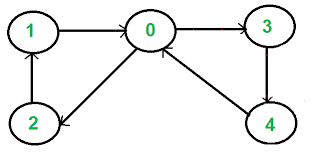

In attention, there is **no notion of space**, it simply acts over a set of vectors. That is why we need to positionally encode the tokens. Also note that each batch element (chunk) is **processed completely independently**.

We created a **"decoder" attention block** because it has triangular masking so that nodes from the future never talk to the past. It is usually used in autoregressive settings, like language modeling. In an "encoder" attention block there is no masking, allowing all tokens to communicate with each other.

We created a **"self-attention" block** because the keys, the queries, and the values are all produced from the same source x. In a "cross-attention" block, the queries still get produced from x, but the keys and the values come from some other external source (e.g. an encoder module).

**"Scaled" attention** additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much a value.

In [26]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [27]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

All the previous code is in the head module in the gpt.py script.

In [28]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [29]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [30]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

## Multi Head Attention

**Multi-head attention** is just applying **multiple attentions in parallel** and concatenating the results.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()

        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

In [ ]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()

        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_heads = MultiHeadAttention(4, n_embd//4)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers

        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)

        # x holds the token identity and the position at which the tokens occur
        x = tok_emb + pos_emb # (B,T,C)

        # apply multi-head aattention
        x = self.sa_heads(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is the current context
        # in each iteration idx will grow:
        # (B, T), (B, T+1), (B, T+2), ..., (B, T+max_new_tokens)

        for _ in range(max_new_tokens):

            # crop the context to the last block_size tokens
            idx_cond = idx[:, -block_size:]

            # get logits for current context (calling forward method)
            logits, _ = self(idx_cond) # (B, T, C)

            # focus only on the last time-step because
            # those are the predictions for what comes next
            logits = logits[:, -1, :] # (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        
        return idx

In [31]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [32]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters


KeyboardInterrupt: 